In [2]:
import numpy as np
from numpy import random 
import torch
import matplotlib.pyplot as plt

**Tensor & Feature map**

Tensor:(h, w, c)=(2,5,3) ;

Feature map:(b, h, w, c)=(3,2,4,5)

<img src="imgs/3-axis_front.png" width="400" height="400" align="left">

<img src="imgs/4-axis_block.png" width="300" height="400" align="center">



## Demo data

### 假设一张输入图片的标签

In [ ]:
# 一个标签框的情况
# gt_boxes = np.array([[[10, 12, 48, 60]]]) 
# 一个gt_box对应的类别标签
# classes = np.array([[2]])

In [3]:
# 当前图片中有两个标签框的情况，每个框由4个坐标表示，设定batch_size=1,
gt_boxes = np.array([[[10, 12, 48, 60],
                      [10, 20, 40, 50]]]) 
# 这两个gt_box各自对应的类别
classes = np.array([[2,4]])  # （batch_size, num_of_gtbox)
m = gt_boxes.shape[1]; print('num of gt_box in one img:',m)  # 标签框个数

# 转变numpy的ndarray的数据类型，到torch的tensor数据类型，
gt_boxes = torch.from_numpy(gt_boxes)
gt_boxes = gt_boxes.type(torch.float32)  # 转换张量的数值类型，方便后续计算
classes = torch.from_numpy(classes)

print('gt_boxes:', gt_boxes.shape, gt_boxes.dtype)
print('classes:', classes.shape, classes.dtype)

num of gt_box in one img: 2
gt_boxes: torch.Size([1, 2, 4]) torch.float32
classes: torch.Size([1, 2]) torch.int32


### 这张图片输入模型后，模型输出的预测值

**假设网络有三层输出(h,w)大小依次为 （16，16） （8，8） （4，4）**

batch_size = 1；  num_of_class = 5（即图中classification的通道数C=5）
<img src="imgs/head_demo.png" width="500" height="400" align="center">

In [4]:
# 所有的分类层
cls_logits_all = [random.rand(1, 5, 16, 16),  # 第一层 
                 random.rand(1, 5, 8, 8),     # 第二层
                 random.rand(1, 5, 4, 4),]    # 第三层
# 所有的中心度层
cnt_logits_all = [random.rand(1, 1, 16, 16),  # 第一层 
                 random.rand(1, 1, 8, 8),     # 第二层
                 random.rand(1, 1, 4, 4),]    # 第三层
# 所有的回归层
reg_preds_all = [random.rand(1, 4, 16, 16),   # 第一层 
                 random.rand(1, 4, 8, 8),     # 第二层
                 random.rand(1, 4, 4, 4),]    # 第三层

fcos_out = [cls_logits_all, cnt_logits_all, reg_preds_all]

**不同层的网络输出**

每一层都包括 分类输出、中心度输出和坐标偏置输出

In [5]:
level_0_out = [cls_logits_all[0], cnt_logits_all[0], reg_preds_all[0]]  # 第一层
level_1_out = [cls_logits_all[1], cnt_logits_all[1], reg_preds_all[1]]  # 第二层
level_2_out = [cls_logits_all[2], cnt_logits_all[2], reg_preds_all[2]]  # 第三层

## 特征图信息编码（映射/转换）

### 特征图上格点坐标与原图坐标的映射(对应)关系

In [6]:
# 以第三层的运算为例 看一下第三个输出层中分类分支特征图的数据形式
cls_logits, cnt_logits, reg_preds = cls_logits_all[2], cnt_logits_all[2], reg_preds_all[2]

cls_logits = torch.from_numpy(cls_logits)  # 将numpy格式数据转换成tensor
cls_logits = cls_logits.permute(0, 2, 3, 1)  # [batch_size,h,w,class_num]

batch_size = cls_logits.shape[0] ;print('batch_size:', batch_size)
hw = cls_logits.shape[1:3]; print('feature_map_hw:', hw)  # 图像的高宽
class_num = cls_logits.shape[3] ;print('class_num:', class_num)
print(cls_logits.shape, cls_logits.dtype)  # 特征图上每一个grid是一个5维的向量  用来表示当前点的类别

batch_size: 1
feature_map_hw: torch.Size([4, 4])
class_num: 5
torch.Size([1, 4, 4, 5]) torch.float64


<img src="imgs/shape.png" width="300" height="400" align="">

tensor([[ 8.,  8.],
        [24.,  8.],
        [40.,  8.],
        [56.,  8.],
        [ 8., 24.],
        [24., 24.],
        [40., 24.],
        [56., 24.],
        [ 8., 40.],
        [24., 40.],
        [40., 40.],
        [56., 40.],
        [ 8., 56.],
        [24., 56.],
        [40., 56.],
        [56., 56.]])

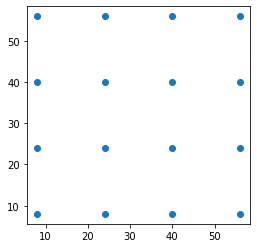

In [7]:
def coords_fmap2orig(feature, stride=16):  # 特征图上的grid对应于原图的位置
    '''
    transfor one fmap coords to orig coords
    Args:
        featurn [batch_size,h,w,c]
        stride int
    Returns ：
        coords [n,2]
    '''
    h, w = feature.shape[1:3]  
    # h, w = 8, 8 # 为演示方便，我们使用尺寸为（4，4）的特征图
    shifts_x = torch.arange(0, w * stride, stride, dtype=torch.float32)
    shifts_y = torch.arange(0, h * stride, stride, dtype=torch.float32)
    shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
    shift_x = torch.reshape(shift_x, [-1])
    shift_y = torch.reshape(shift_y, [-1])
    coords = torch.stack([shift_x, shift_y], -1) + (stride // 2)  # 中心点偏置
    # 可视化一下，看看
    plt.figure(figsize=(4,4))
    plt.scatter(coords[:,0], coords[:,1])
    # plt.savefig('grid.png')
    return coords

coords = coords_fmap2orig(cls_logits)
coords

<img src="imgs/perception field.png" width="700" height="400" align="">

利用形状转换，将特征图降维

In [8]:
# cls_logits 
cls_logits = cls_logits.reshape((batch_size, -1, class_num))  # [batch_size,h*w,class_num]
cls_logits.shape

torch.Size([1, 16, 5])

<img src="imgs/reshape1.png" width="600" height="400" align="bottom">

In [9]:
# 4 reshape cnt
cnt_logits = torch.from_numpy(cnt_logits)
cnt_logits = cnt_logits.permute(0, 2, 3, 1)   
cnt_logits = cnt_logits.reshape((batch_size, -1, 1))    # [batch_size,h*w,1]
cnt_logits.shape

torch.Size([1, 16, 1])

In [10]:
# 5 reshape reg
reg_preds = torch.from_numpy(reg_preds)
reg_preds = reg_preds.permute(0, 2, 3, 1)
reg_preds = reg_preds.reshape((batch_size, -1, 4))  #  # [batch_size,h*w,4]
reg_preds.shape

torch.Size([1, 16, 4])

In [11]:
# 转换后特征图的形状特征
h_mul_w = cls_logits.shape[1] 
h_mul_w  # h*w

16

### 寻找特征图上的点与gtbox边缘的偏置关系

&emsp;&emsp;特征图上feature_grid的坐标（x_fea,y_fea）先映射到原图上(x_img, y_img), 然后找点(x_img, y_img)与gtbox坐标(x_min,y_min, x_max,y_max)的偏置关系:当前点到框的各边的距离(l, t, r, b)

<img src="imgs/tensor2fea2img.png" width="900" height="400" align="bottom">

In [12]:
x = coords[:, 0] ; print(x)
y = coords[:, 1] ; print(y)

tensor([ 8., 24., 40., 56.,  8., 24., 40., 56.,  8., 24., 40., 56.,  8., 24.,
        40., 56.])
tensor([ 8.,  8.,  8.,  8., 24., 24., 24., 24., 40., 40., 40., 40., 56., 56.,
        56., 56.])


In [13]:
# gt_boxes = np.array([[[10, 12, 48, 60],
#                       [10, 20, 40, 50]]]) 
gt_boxes[..., 0]  # 取第一列  所有gt框的xmin

tensor([[10., 10.]])

In [14]:
# [1,h*w,1]-[batch_size,1,m]-->[batch_size,h*w,m]
l_off = x[None, :, None] - gt_boxes[..., 0][:, None, :]   # None 增加维度用的
l_off

tensor([[[-2., -2.],
         [14., 14.],
         [30., 30.],
         [46., 46.],
         [-2., -2.],
         [14., 14.],
         [30., 30.],
         [46., 46.],
         [-2., -2.],
         [14., 14.],
         [30., 30.],
         [46., 46.],
         [-2., -2.],
         [14., 14.],
         [30., 30.],
         [46., 46.]]])

<img src="imgs/sub.png" width="400" height="400" align="bottom">

In [16]:
t_off = y[None, :, None] - gt_boxes[..., 1][:, None, :]

r_off = gt_boxes[..., 2][:, None, :] - x[None, :, None]
b_off = gt_boxes[..., 3][:, None, :] - y[None, :, None]

In [17]:
ltrb_off = torch.stack([l_off, t_off, r_off, b_off], dim=-1)  # [batch_size,h*w,m,4]
ltrb_off.shape

torch.Size([1, 16, 2, 4])

In [18]:
# 16个(x_img,y_img)点与这个gt_box(x_min,y_min,x_max,y_max)的偏置关系
ltrb_off

tensor([[[[ -2.,  -4.,  40.,  52.],
          [ -2., -12.,  32.,  42.]],

         [[ 14.,  -4.,  24.,  52.],
          [ 14., -12.,  16.,  42.]],

         [[ 30.,  -4.,   8.,  52.],
          [ 30., -12.,   0.,  42.]],

         [[ 46.,  -4.,  -8.,  52.],
          [ 46., -12., -16.,  42.]],

         [[ -2.,  12.,  40.,  36.],
          [ -2.,   4.,  32.,  26.]],

         [[ 14.,  12.,  24.,  36.],
          [ 14.,   4.,  16.,  26.]],

         [[ 30.,  12.,   8.,  36.],
          [ 30.,   4.,   0.,  26.]],

         [[ 46.,  12.,  -8.,  36.],
          [ 46.,   4., -16.,  26.]],

         [[ -2.,  28.,  40.,  20.],
          [ -2.,  20.,  32.,  10.]],

         [[ 14.,  28.,  24.,  20.],
          [ 14.,  20.,  16.,  10.]],

         [[ 30.,  28.,   8.,  20.],
          [ 30.,  20.,   0.,  10.]],

         [[ 46.,  28.,  -8.,  20.],
          [ 46.,  20., -16.,  10.]],

         [[ -2.,  44.,  40.,   4.],
          [ -2.,  36.,  32.,  -6.]],

         [[ 14.,  44.,  24.,   4.],
  

### 选择feature map上的正负样本点
&emsp;&emsp;对于feature map上的各个点（x_fea,y_fea），只要这个点对应的(x_img, y_img)落到了gt bbox(x_min,y_min, x_max,y_max)区域中，那么这个点就是正样本；而如果这个点多在多个bbox中，那个这个点就是模糊样本，目前采用面积最小的bbox作为这个点的回归目标。目标框的回归参数是：当前点到框的各边的距离(l, t, r, b)。
<img src="imgs/ancher free.png" width="500" height="400" align="bottom">
>```python
l_off = x[None, :, None] - gt_boxes[..., 0][:, None, :]
t_off = y[None, :, None] - gt_boxes[..., 1][:, None, :]
r_off = gt_boxes[..., 2][:, None, :] - x[None, :, None]
b_off = gt_boxes[..., 3][:, None, :] - y[None, :, None]
ltrb_off = torch.stack([l_off, t_off, r_off, b_off], dim=-1)  # [batch_size,h*w,m,4]
```

tensor([[[1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.]]])


In [20]:
off_min = torch.min(ltrb_off, dim=-1)[0]  # [batch_size,h*w,m]
off_max = torch.max(ltrb_off, dim=-1)[0]  # [batch_size,h*w,m]

In [21]:
off_min > 0

tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [1, 1],
         [1, 0],
         [0, 0],
         [0, 0],
         [1, 1],
         [1, 0],
         [0, 0],
         [0, 0],
         [1, 0],
         [1, 0],
         [0, 0]]], dtype=torch.uint8)

In [25]:
mask_in_gtboxes = off_min > 0  # 满足条件的为真 1 保留

In [26]:
mask_in_level = (off_max > 32) & (off_max <= 64)

<img src="imgs/scale.png" width="600" height="400" align="bottom">

### 寻找正样本点与gtbox中心的偏置关系
<img src="imgs/ancher free.png" width="500" height="400" align="bottom">

In [27]:
# 计算gt_box的中心  我们假设有两个gt box 
gt_center_x = (gt_boxes[..., 0] + gt_boxes[..., 2]) / 2  ; print(gt_center_x)
gt_center_y = (gt_boxes[..., 1] + gt_boxes[..., 3]) / 2 ; print(gt_center_y)

tensor([[29., 25.]])
tensor([[36., 35.]])


In [28]:
# gt_box 中心点与 feat_map grid 间的偏置关系
# | x - gt_center_x | x方向上的距离
# | y - gt_center_y | y方向上的距离
c_l_off = x[None, :, None] - gt_center_x[:, None, :]  # [1,h*w,1]-[batch_size,1,m]-->[batch_size,h*w,m]
c_t_off = y[None, :, None] - gt_center_y[:, None, :]
c_r_off = gt_center_x[:, None, :] - x[None, :, None]
c_b_off = gt_center_y[:, None, :] - y[None, :, None]


In [29]:
c_ltrb_off = torch.stack([c_l_off, c_t_off, c_r_off, c_b_off], dim=-1)  # [batch_size,h*w,m,4]

In [30]:
c_off_max = torch.max(c_ltrb_off, dim=-1)[0]  # 相对于gt_box center 偏的最远的grid
c_off_max

tensor([[[28., 27.],
         [28., 27.],
         [28., 27.],
         [28., 31.],
         [21., 17.],
         [12., 11.],
         [12., 15.],
         [27., 31.],
         [21., 17.],
         [ 5.,  5.],
         [11., 15.],
         [27., 31.],
         [21., 21.],
         [20., 21.],
         [20., 21.],
         [27., 31.]]])

In [31]:
mask_center = c_off_max < 1.5 * 16  # 1 * stride / 1.5*stride
mask_center

tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [1, 1],
         [1, 1],
         [1, 1],
         [0, 0],
         [1, 1],
         [1, 1],
         [1, 1],
         [0, 0],
         [1, 1],
         [1, 1],
         [1, 1],
         [0, 0]]], dtype=torch.uint8)

<img src="imgs/center.png" width="400" height="400" align="bottom">

<img src="imgs/level_scale2.png" width="400" height="400" align="bottom">

<img src="imgs/level_scale1.png" width="400" height="400" align="bottom">

In [32]:
mask_pos = mask_in_gtboxes & mask_in_level & mask_center 
print(mask_pos,mask_pos.shape)

tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [1, 0],
         [1, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [1, 0],
         [1, 0],
         [0, 0]]], dtype=torch.uint8) torch.Size([1, 16, 2])


## 根据gt_box面积分配模糊正样本点

对于feature map上的各个点（x_fea,y_fea），只要这个点对应的(x_img, y_img)落到了gt bbox(x_min,y_min, x_max,y_max)区域中，那么这个点就是正样本；而如果这个点多在多个bbox中，那个这个点就是模糊样本，目前采用面积最小的bbox作为这个点的回归目标。目标框的回归方式也从回归顶点坐标(x, y, x, y)到回归当前点到框的各边的距离(l, t, r, b)。
<img src="imgs/ancher free.png" width="500" height="400" align="bottom">

In [33]:
areas = (ltrb_off[..., 0] + ltrb_off[..., 2]) * (ltrb_off[..., 1] + ltrb_off[..., 3])  # [batch_size,h*w,m]
print(areas)  # 框的面积值 

tensor([[[1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.],
         [1824.,  900.]]])


In [35]:
areas[~mask_pos] = 99999 # 初始化非样本点 
areas

tensor([[[99999., 99999.],
         [99999., 99999.],
         [99999., 99999.],
         [99999., 99999.],
         [99999., 99999.],
         [ 1824., 99999.],
         [ 1824., 99999.],
         [99999., 99999.],
         [99999., 99999.],
         [99999., 99999.],
         [99999., 99999.],
         [99999., 99999.],
         [99999., 99999.],
         [ 1824., 99999.],
         [ 1824., 99999.],
         [99999., 99999.]]])

In [36]:
areas_min_ind = torch.min(areas, dim=-1)[1]  # [batch_size,h*w]
areas_min_ind

tensor([[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]])

In [37]:
areas_min_ind.unsqueeze(dim=-1)

tensor([[[1],
         [1],
         [1],
         [1],
         [1],
         [0],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [0],
         [0],
         [1]]])

In [38]:
torch.zeros_like(areas, dtype=torch.uint8)

tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0]]], dtype=torch.uint8)

In [43]:
# 生成独热向量
index = torch.zeros_like(areas, dtype=torch.uint8).scatter_(-1, 
                                                    areas_min_ind.unsqueeze(dim=-1),  # 增加一个维度
                                                    1)
print(index.shape)
index

torch.Size([1, 16, 2])


tensor([[[0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [1, 0],
         [1, 0],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [1, 0],
         [1, 0],
         [0, 1]]], dtype=torch.uint8)

In [42]:
# 指定一下面积最小的那个框，特征图上的每个格点对应到它所属的面积最小的gt_box
print(ltrb_off.shape)
reg_targets = ltrb_off[index]  # [batch_size*h*w, 4]
print(reg_targets.shape)
reg_targets

torch.Size([1, 16, 2, 4])
torch.Size([16, 4])


tensor([[ -2., -12.,  32.,  42.],
        [ 14., -12.,  16.,  42.],
        [ 30., -12.,   0.,  42.],
        [ 46., -12., -16.,  42.],
        [ -2.,   4.,  32.,  26.],
        [ 14.,  12.,  24.,  36.],
        [ 30.,  12.,   8.,  36.],
        [ 46.,   4., -16.,  26.],
        [ -2.,  20.,  32.,  10.],
        [ 14.,  20.,  16.,  10.],
        [ 30.,  20.,   0.,  10.],
        [ 46.,  20., -16.,  10.],
        [ -2.,  36.,  32.,  -6.],
        [ 14.,  44.,  24.,   4.],
        [ 30.,  44.,   8.,   4.],
        [ 46.,  36., -16.,  -6.]])

In [56]:
classes = torch.broadcast_tensors(classes[:, None, :], areas.long())[0] # areas.long() 转换area的数值类型
classes

tensor([[[2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4],
         [2, 4]]], dtype=torch.int32)

In [57]:
select = torch.zeros_like(areas, dtype=torch.uint8).scatter_(-1, areas_min_ind.unsqueeze(dim=-1), 1)
cls_targets = classes[select]
cls_targets

tensor([4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 2, 4], dtype=torch.int32)

## [cnt_targets 在做什么?](https://blog.csdn.net/shanglianlm/article/details/89007219)
**centerness**

&emsp;&emsp;通过center-ness来度量当前位置和物体中心间的距离，即FCOS将点的坐标在目标中的位置因素也考虑进来，越靠近中间权重越大。
<img src="imgs/centerness.jpg" width="500" height="400" align="bottom">


&emsp;&emsp;在训练的过程中通过损失函数，我们会约束center-ness的值，使得其接近于0，使得分布在目标位置边缘的低质量框能够尽可能的靠近中心。在最终使用该网络的过程中，非极大值抑制(NMS)就可以轻松滤除这些低质量的边界框，提高检测性能。
<img src="imgs/equation3.png" width="500" height="400" align="bottom">


In [88]:
left_right_min = torch.min(reg_targets[..., 0], reg_targets[..., 2]) ; print(left_right_min)
left_right_max = torch.max(reg_targets[..., 0], reg_targets[..., 2]) ; print(left_right_max)
top_bottom_min = torch.min(reg_targets[..., 1], reg_targets[..., 3])
top_bottom_max = torch.max(reg_targets[..., 1], reg_targets[..., 3])
# 上面的值拿来计算中心目标
cnt_targets = ((left_right_min * top_bottom_min) / (left_right_max * top_bottom_max + 1e-4)).sqrt().unsqueeze(
    dim=-1)  # [batch_size,h*w,1]

tensor([ -2.,  14.,   0., -16.,  -2.,  14.,   8., -16.,  -2.,  14.,   0., -16.,
         -2.,  14.,   8., -16.])
tensor([32., 16., 30., 46., 32., 24., 30., 46., 32., 16., 30., 46., 32., 24.,
        30., 46.])


In [89]:
cnt_targets

tensor([[0.1336],
        [   nan],
        [-0.0000],
        [0.3152],
        [   nan],
        [0.4410],
        [0.2981],
        [   nan],
        [   nan],
        [0.6614],
        [0.0000],
        [   nan],
        [0.1021],
        [0.2303],
        [0.1557],
        [0.2408]])

## 根据mask制作taragets

In [90]:
# mask_pos = mask_in_gtboxes & mask_in_level & mask_center 
mask_pos.long().sum(dim=-1)  # [batch_size,h*w]

tensor([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]])

In [91]:
mask_pos_2 = mask_pos.long().sum(dim=-1)  # [batch_size,h*w]

In [92]:
mask_pos_2 = mask_pos_2 >= 1
mask_pos_2

tensor([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]], dtype=torch.uint8)

In [93]:
cls_targets

tensor([4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 2, 4], dtype=torch.int32)

In [95]:
# 对于只有一个gt_box的情况
cls_targets[~mask_pos_2.squeeze()] = 0   # [batch_size,h*w,1]
cnt_targets[~mask_pos_2.squeeze()] = -1  
reg_targets[~mask_pos_2.squeeze()] = -1

print(cls_targets)
print(cnt_targets)
print(reg_targets)

tensor([0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0], dtype=torch.int32)
tensor([[-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [ 0.4410],
        [ 0.2981],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [ 0.2303],
        [ 0.1557],
        [-1.0000]])
tensor([[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [14., 12., 24., 36.],
        [30., 12.,  8., 36.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [14., 44., 24.,  4.],
        [30., 44.,  8.,  4.],
        [-1., -1., -1., -1.]])


## 总体函数

In [ ]:
  def _gen_level_targets(out, gt_boxes, classes, stride, limit_range, sample_radiu_ratio=1.5):
        '''
        Args  
        out list contains [[batch_size,class_num,h,w],[batch_size,1,h,w],[batch_size,4,h,w]]  
        gt_boxes [batch_size,m,4]  
        classes [batch_size,m]  
        stride int  
        limit_range list [min,max]  
        Returns  
        cls_targets,cnt_targets,reg_targets
        '''
        # 1 三个同一层的分类 中心 定位的 预测数据
        cls_logits, cnt_logits, reg_preds = out
        batch_size = cls_logits.shape[0]
        class_num = cls_logits.shape[1]
        # 2 一个图片有多少个标签框
        m = gt_boxes.shape[1]
        # 3 reshape (batch_size, h*w, n)
        cls_logits = cls_logits.permute(0, 2, 3, 1)  # [batch_size,h,w,class_num]
        coords = coords_fmap2orig(cls_logits, stride).to(device=gt_boxes.device)  # [h*w,2]

        cls_logits = cls_logits.reshape((batch_size, -1, class_num))  # [batch_size,h*w,class_num]
        # 4 reshape cnt
        cnt_logits = cnt_logits.permute(0, 2, 3, 1)   
        cnt_logits = cnt_logits.reshape((batch_size, -1, 1))    # [batch_size,h*w,1]
        # 5 reshape reg
        reg_preds = reg_preds.permute(0, 2, 3, 1)
        reg_preds = reg_preds.reshape((batch_size, -1, 4))  #  # [batch_size,h*w,4]

        h_mul_w = cls_logits.shape[1]  # h*w

        x = coords[:, 0]
        y = coords[:, 1]
        # 6 判断gt_box 包含了特征图上哪些grid(格点)
        l_off = x[None, :, None] - gt_boxes[..., 0][:, None, :]  # [1,h*w,1]-[batch_size,1,m]-->[batch_size,h*w,m]
        t_off = y[None, :, None] - gt_boxes[..., 1][:, None, :]
        
        r_off = gt_boxes[..., 2][:, None, :] - x[None, :, None]
        b_off = gt_boxes[..., 3][:, None, :] - y[None, :, None]
        
        ltrb_off = torch.stack([l_off, t_off, r_off, b_off], dim=-1)  # [batch_size,h*w,m,4]

        areas = (ltrb_off[..., 0] + ltrb_off[..., 2]) * (ltrb_off[..., 1] + ltrb_off[..., 3])  # [batch_size,h*w,m]

        
        off_min = torch.min(ltrb_off, dim=-1)[0]  # [batch_size,h*w,m]
        off_max = torch.max(ltrb_off, dim=-1)[0]  # [batch_size,h*w,m]

        mask_in_gtboxes = off_min > 0  # feature map 上的gird 是不是在框里
        mask_in_level = (off_max > limit_range[0]) & (off_max <= limit_range[1])  # 这个框是不是在这一层里
        # 7 找到离gt box 不远（1*stride）的grid
        radiu = stride * sample_radiu_ratio
        gt_center_x = (gt_boxes[..., 0] + gt_boxes[..., 2]) / 2
        gt_center_y = (gt_boxes[..., 1] + gt_boxes[..., 3]) / 2
        
        c_l_off = x[None, :, None] - gt_center_x[:, None, :]  # [1,h*w,1]-[batch_size,1,m]-->[batch_size,h*w,m]
        c_t_off = y[None, :, None] - gt_center_y[:, None, :]
        c_r_off = gt_center_x[:, None, :] - x[None, :, None]
        c_b_off = gt_center_y[:, None, :] - y[None, :, None]
        
        c_ltrb_off = torch.stack([c_l_off, c_t_off, c_r_off, c_b_off], dim=-1)  # [batch_size,h*w,m,4]
        c_off_max = torch.max(c_ltrb_off, dim=-1)[0]
        mask_center = c_off_max < radiu
        # 选择 满足条件的grid
        mask_pos = mask_in_gtboxes & mask_in_level & mask_center  # [batch_size,h*w,m]

        areas[~mask_pos] = 99999999
        areas_min_ind = torch.min(areas, dim=-1)[1]  # [batch_size,h*w]
        reg_targets = ltrb_off[torch.zeros_like(areas, dtype=torch.uint8).scatter_(-1, areas_min_ind.unsqueeze(dim=-1),
                                                                                   1)]  # [batch_size*h*w,4]
        reg_targets = torch.reshape(reg_targets, (batch_size, -1, 4))  # [batch_size,h*w,4]

        classes = torch.broadcast_tensors(classes[:, None, :], areas.long())[0]  # [batch_size,h*w,m]
        cls_targets = classes[
            torch.zeros_like(areas, dtype=torch.uint8).scatter_(-1, areas_min_ind.unsqueeze(dim=-1), 1)]
        cls_targets = torch.reshape(cls_targets, (batch_size, -1, 1))  # [batch_size,h*w,1]

        left_right_min = torch.min(reg_targets[..., 0], reg_targets[..., 2])  # [batch_size,h*w]
        left_right_max = torch.max(reg_targets[..., 0], reg_targets[..., 2])
        top_bottom_min = torch.min(reg_targets[..., 1], reg_targets[..., 3])
        top_bottom_max = torch.max(reg_targets[..., 1], reg_targets[..., 3])
        cnt_targets = ((left_right_min * top_bottom_min) / (left_right_max * top_bottom_max + 1e-10)).sqrt().unsqueeze(
            dim=-1)  # [batch_size,h*w,1]

        assert reg_targets.shape == (batch_size, h_mul_w, 4)
        assert cls_targets.shape == (batch_size, h_mul_w, 1)
        assert cnt_targets.shape == (batch_size, h_mul_w, 1)

        # process neg coords
        mask_pos_2 = mask_pos.long().sum(dim=-1)  # [batch_size,h*w]
        # num_pos=mask_pos_2.sum(dim=-1)
        # assert num_pos.shape==(batch_size,)
        mask_pos_2 = mask_pos_2 >= 1  # 再确认一下
        assert mask_pos_2.shape == (batch_size, h_mul_w)
        cls_targets[~mask_pos_2] = 0   # [batch_size,h*w,1]
        cnt_targets[~mask_pos_2] = -1  
        reg_targets[~mask_pos_2] = -1

        return cls_targets, cnt_targets, reg_targets